In [13]:
from matplotlib.animation import FuncAnimation as animation
from matplotlib.animation import PillowWriter
import matplotlib.pyplot as plt
import numpy as np

In [14]:
plt.style.use(['dark_background'])
%matplotlib notebook

In [15]:
inf_col = 'r'
rem_col = 'lime'
ded_col = 'k'
sus_col = 'grey'

In [16]:
infection_radius = 0.7
recovery_rate = 0.0006
death_rate = .001
stage_dimension = 100 # MxM square stage

In [17]:
init = [500, # pop. size
        4, # infected
        0, #recovered
        0] #dead

In [18]:
maskBool=False
maskMod=.16

SDbool=False
SDmod= .1

<IPython.core.display.Javascript object>


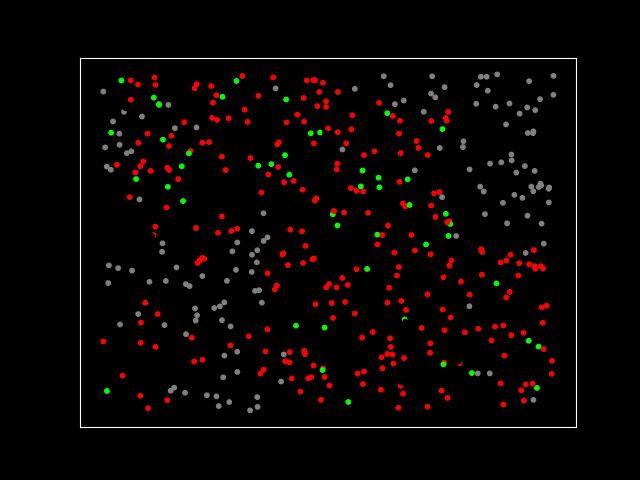

In [19]:
class Sim():
    def __init__(self, init):
        #init = [N,inf,rec]
        
        self.N = init[0]
        suc = self.N - init[1] - (init[2] + init[3])
        self.cols = np.repeat([sus_col, inf_col, rem_col, ded_col],
                              [suc,init[1], init[2], init[3]])
        self.low, self.high = -stage_dimension/2, stage_dimension/2
        self.pos = np.random.uniform(self.low,
                                     self.high,
                                     size=(2,self.N))
        
        self.stream = self.data_stream()
        self.fig, self.ax = plt.subplots();
        
        self.ani = animation(self.fig,
                             self.update, 
                             np.arange(1, 210),
                             interval = 10, 
                             init_func = self.setup,
                             blit=True)

        #self.ani.save('Covid.gif', writer = PillowWriter(fps = 12)) #Salvando gif

    def setup(self):
        p, c = next(self.stream)
        
        self.scat = self.ax.scatter(x = p[0,:],
                                    y = p[1,:],
                                    c = c.T)
        return self.scat,
    
    def arg_within_radius(self, inf, susceptible, r):
        #inf 1x2, succeptible nx2 matrices
        dist = np.sqrt(((inf - susceptible)**2).sum(axis = 1))
        return np.argwhere(dist < r).ravel()
    
    def data_stream(self):
        while True:
            removed = 0
            #move points
            jitter = 0.5*np.random.normal(0, 1, size = (2, self.N))
            self.pos[0:2,:] += jitter

            #infect and recover---------
            #get infected people
            inf = np.argwhere(self.cols == inf_col).ravel()
            inf_people = self.pos[:,inf].T

            for i in inf_people:
                suc = np.argwhere(self.cols == sus_col).ravel()
                suc_people = self.pos[:,suc].T

                infect = self.arg_within_radius(i,
                                                suc_people,
                                                infection_radius)
                infect_index = suc[infect]
                self.cols[infect_index] = inf_col
            
            #adjust out of bounds
            x1=np.where(self.pos[0:2,:] < self.low)
            x2=np.where(self.pos[0:2,:] > self.high)
            self.pos[0:2,:][x1], self.pos[0:2,:][x2] = self.low, self.high
            
            #yield [self.pos,self.cols],
            r = np.random.uniform(0, 1, size = inf.size)
            rec = np.argwhere(r < recovery_rate).T
            recovered_idx = inf[rec]
            self.cols[recovered_idx] = rem_col

            d = np.random.uniform(0, 1, size = (inf.size))
            dead = np.argwhere(d < death_rate).T
            dead_idx = inf[dead]
            self.cols[dead_idx] = ded_col
            ded = np.argwhere(self.cols == ded_col).ravel()
            ded_people = self.pos[:,dead].T
            for dd in ded_people:
                removed += 1

            ##Uncomment below to print number of deaths
            #print(len(ded))
            yield self.pos, self.cols
            
    def update(self, i):
        data,c = next(self.stream)
        self.scat.set_offsets(data[0:2,:].T)
        self.scat.set_sizes(np.zeros(self.N)+10)
        self.scat.set_color(c.T)
        return self.scat,

S = Sim(init)
plt.xticks([])
plt.yticks([])
plt.show()